In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prep

loading csv files from google drive

In [ ]:
directory = '/content/drive/My Drive/NBA Season Data/2020-21'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

In [ ]:
files.keys()

dict_keys(['box_scores', 'putback', 'post_up', 'assists', 'cut', 'screen_assists', 'drives', 'off_screen', 'hand_off', 'pnr_handler', 'isolation', 'catch_and_shoot', 'pnr_man', 'touches', 'height_weight', 'spot_up', 'shot_chart'])

In [ ]:
for name in files.keys():
  print(f"STAT: {name}")
  files[name].info()
  print()

STAT: box_scores
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PLAYER  540 non-null    object 
 1   TEAM    540 non-null    object 
 2   MIN     540 non-null    float64
 3   FGA     540 non-null    float64
 4   3PA     540 non-null    float64
 5   AST     540 non-null    float64
dtypes: float64(4), object(2)
memory usage: 25.4+ KB

STAT: putback
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PLAYER        280 non-null    object 
 1   TEAM          280 non-null    object 
 2   PUTBACK FREQ  280 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.7+ KB

STAT: post_up
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 3 columns):
 #   Column    Non-Null C

merging dataframes

In [ ]:
players = pd.DataFrame()
for stat in files.keys():
  if players.empty:
    players = files[stat]
  else:
    players = pd.merge(players, files[stat], how="left", on = ["PLAYER", "TEAM"])

players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               540 non-null    object 
 1   TEAM                 540 non-null    object 
 2   MIN                  540 non-null    float64
 3   FGA                  540 non-null    float64
 4   3PA                  540 non-null    float64
 5   AST                  540 non-null    float64
 6   PUTBACK FREQ         257 non-null    float64
 7   POST UPS             540 non-null    float64
 8   PASSES MADE          540 non-null    float64
 9   CUT FREQ             300 non-null    float64
 10  SCREEN ASSISTS       540 non-null    float64
 11  DRIVES               540 non-null    float64
 12  PASS OFF DRIVE       540 non-null    float64
 13  OFF SCREEN FREQ      190 non-null    float64
 14  HANDOFF FREQ         244 non-null    float64
 15  PNR HANDLER FREQ     276 non-null    flo

In [ ]:
directory = '/content/drive/My Drive/NBA Season Data/2020-21'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

players18_19 = pd.DataFrame()
for stat in files.keys():
  if players18_19.empty:
    players18_19 = files[stat]
  else:
    players18_19 = pd.merge(players18_19, files[stat], how="left", on = ["PLAYER", "TEAM"])

players18_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               540 non-null    object 
 1   TEAM                 540 non-null    object 
 2   MIN                  540 non-null    float64
 3   FGA                  540 non-null    float64
 4   3PA                  540 non-null    float64
 5   AST                  540 non-null    float64
 6   PUTBACK FREQ         257 non-null    float64
 7   POST UPS             540 non-null    float64
 8   PASSES MADE          540 non-null    float64
 9   CUT FREQ             300 non-null    float64
 10  SCREEN ASSISTS       540 non-null    float64
 11  DRIVES               540 non-null    float64
 12  PASS OFF DRIVE       540 non-null    float64
 13  OFF SCREEN FREQ      190 non-null    float64
 14  HANDOFF FREQ         244 non-null    float64
 15  PNR HANDLER FREQ     276 non-null    flo

In [ ]:
from sklearn.base import TransformerMixin, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

class CleanDataset(TransformerMixin):

  def fit(self, X, y=None):
    return self

  def height_to_inches(self, height):
    ft, inches = height.split('-')
    return int(ft) * 12 + int(inches)

  def transform(self, X, y=None):
    # fill NULL stats
    X.fillna(0, inplace=True)

    # filter out players with less than 15 minutes
    X = X.loc[X['MIN'] >= 15,]

    # convert height
    X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)

    #convert all columns to numeric
    numeric_columns = X.columns.difference(['PLAYER', 'TEAM'])
    X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)

    return X

class NormalizeDataset(TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):

    # Normalize 'SCREEN ASSISTS'
    X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] = X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] / X['AST']

    # Normalize 'PASS OFF DRIVE' when 'DRIVES' is not 0
    X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] = X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] / X.loc[X['DRIVES'] != 0, 'DRIVES']

    # Normalize columns in cols_norm_touches
    cols_norm_touches = ['AST', 'PASSES MADE', 'DRIVES', 'FRONT CT TOUCHES', 'ELBOW TOUCHES', 'PAINT TOUCHES']
    for stat in cols_norm_touches:
        X.loc[:, stat] = (X[stat] / X['TOUCHES']) * 100

    # Rename columns related to touches
    X.rename(columns={'AST': 'AST PER TOUCHES', 'PASSES MADE': 'PASSES PER TOUCHES', 'DRIVES': 'DRIVES PER TOUCHES', 'FRONT CT TOUCHES': 'FRONT CT TOUCH FREQ', 'PAINT TOUCHES':'PAINT TOUCHES FREQ', 'ELBOW TOUCHES':'ELBOW TOUCH FREQ'}, inplace=True)

    # Normalize 'CATCH AND SHOOT 3 FREQ' and 'CORNER 3 FREQ'
    cols_norm_3pa = ['CATCH AND SHOOT 3PA', 'CORNER 3 FGA']
    X['CATCH AND SHOOT 3 FREQ'] = 100 * X['CATCH AND SHOOT 3PA'] / np.where(X['3PA'] != 0, X['3PA'], 1)
    X['CORNER 3 FREQ'] = 100 * X['CORNER 3 FGA'] / np.where(X['3PA'] != 0, X['3PA'], 1)

    # Normalize columns in cols_norm_fga
    cols_norm_fga = ['CATCH AND SHOOT FGA', 'IN THE PAINT FGA', 'MID RANGE FGA', 'CATCH AND SHOOT 3PA', 'CORNER 3 FGA', 'POST UPS']
    for stat in cols_norm_fga:
        X.loc[:, stat] = 100 * X[stat] / X['FGA']

    # Rename columns related to FGA
    X.rename(columns={'CATCH AND SHOOT FGA': 'CATCH AND SHOOT FREQ', 'IN THE PAINT FGA': 'IN THE PAINT FREQ', 'MID RANGE FGA': 'MID RANGE FREQ', 'CATCH AND SHOOT 3PA': 'CATCH AND SHOOT 3 TFREQ', 'CORNER 3 FGA': 'CORNER 3 TFREQ', 'POST UPS': 'POST UPS FREQ'}, inplace=True)

    # Drop unnecessary columns
    X.drop(['MIN', 'FGA', '3PA', 'TOUCHES'], axis=1, inplace=True)

    X.reset_index(inplace=True)
    X.drop('index', axis=1, inplace=True)

    # return numerical portion for scaler (preprocessed dataset will be preserved bc drop creates new df)
    return X

class Cluster(ClusterMixin):
  def __init__(self, kmeans = None, num_clusters = 8) -> None:
    self.kmeans = kmeans
    self.num_clusters = num_clusters

  def fit(self, X, y=None):
    if not self.kmeans:
      print("should fire twice")
      self.kmeans = KMeans(n_clusters=self.num_clusters)
      self.kmeans.fit(X)
    return self

  def transform(self, X, y=None):

    newX = pd.DataFrame()
    # get cluster labels
    print("something")
    newX['CLUSTER'] = self.kmeans.predict(X)

    # get soft cluster distances
    col_names =[f'CLUSTER {i} DISTANCE' for i in range(self.num_clusters)]
    newX.loc[:, col_names] = self.kmeans.transform(X)

    # get silhouette scores
    silhouette_coeffs = silhouette_samples(X, self.kmeans.labels_)
    newX.loc[:,'SILHOUETTE COEFFICIENT'] = silhouette_coeffs

    return newX

cluster_pipeline = Pipeline([('std_scaler', StandardScaler()),
                            ('cluster', Cluster(None, num_clusters=8))])

preprocess_pipeline = Pipeline([('clean', CleanDataset()),
                                ('normalize', NormalizeDataset())])



In [ ]:
# players_clean = preprocess_pipeline.fit_transform(players)
# # players_clean.info()
# clusters = cluster_pipeline.fit_transform(players_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
# result = pd.concat([players_clean, clusters], axis=1)


players18_19_clean = preprocess_pipeline.fit_transform(players18_19)
cluster18_19 = cluster_pipeline.fit_transform(players18_19_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
result18_19 = pd.concat([players18_19_clean, cluster18_19], axis=1)
result18_19

<ipython-input-7-49fd5c76499f>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)
<ipython-input-7-49fd5c76499f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
<ipython-input-7-49fd5c76499f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

should fire twice
something


,PLAYER,TEAM,AST PER TOUCHES,PUTBACK FREQ,POST UPS FREQ,PASSES PER TOUCHES,CUT FREQ,SCREEN ASSISTS,DRIVES PER TOUCHES,PASS OFF DRIVE,...,CLUSTER,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE,SILHOUETTE COEFFICIENT
0,Stephen Curry,GSW,7.134071,0.8,0.460829,63.468635,4.1,0.206897,13.407134,0.385321,...,1,9.545063,5.310168,11.858369,6.283617,9.536304,8.527519,6.501111,12.816062,0.070053
1,Bradley Beal,WAS,6.376812,2.7,2.173913,54.782609,6.4,0.068182,22.753623,0.292994,...,1,8.522876,4.047651,9.491152,4.708161,7.467927,6.244006,5.492995,10.877529,0.014140
2,Damian Lillard,POR,9.225092,0.9,2.010050,63.591636,3.2,0.040000,16.728167,0.367647,...,1,11.824366,4.708275,13.199306,8.838136,11.158635,10.175441,6.896735,13.837590,0.204870
3,Joel Embiid,PHI,3.954802,6.6,69.886364,61.864407,3.5,1.000000,5.084746,0.194444,...,4,9.938024,8.947505,7.284963,9.348949,5.354069,8.188885,9.987098,9.086569,0.182430
4,Giannis Antetokounmpo,MIL,8.428571,4.1,25.000000,59.142857,8.5,0.474576,16.142857,0.318584,...,1,10.350522,5.505387,8.466416,8.618898,7.158732,8.057147,7.754583,9.002557,0.174537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,P.J. Tucker,MIL,4.958678,0.0,2.941176,81.818182,0.0,1.250000,2.479339,0.500000,...,0,5.930513,12.475270,11.600804,9.445308,9.832100,8.221087,10.696062,13.975904,0.238348
365,Romeo Langford,BOS,4.861111,0.0,6.060606,68.750000,0.0,0.142857,11.805556,0.352941,...,5,4.493208,8.193566,7.823766,5.296034,6.076639,3.065289,6.468686,10.492621,0.166749
366,Gary Clark,PHI,3.319502,0.0,2.941176,82.157676,0.0,0.625000,1.659751,0.500000,...,0,4.486547,10.564707,9.911095,7.437262,7.792573,6.217758,8.743057,12.149983,0.207787
367,Matthew Dellavedova,CLE,10.843373,0.0,0.000000,85.060241,0.0,0.066667,8.433735,0.428571,...,6,7.080620,6.067130,9.908947,6.065276,7.778488,5.773342,3.531924,11.582593,0.272564


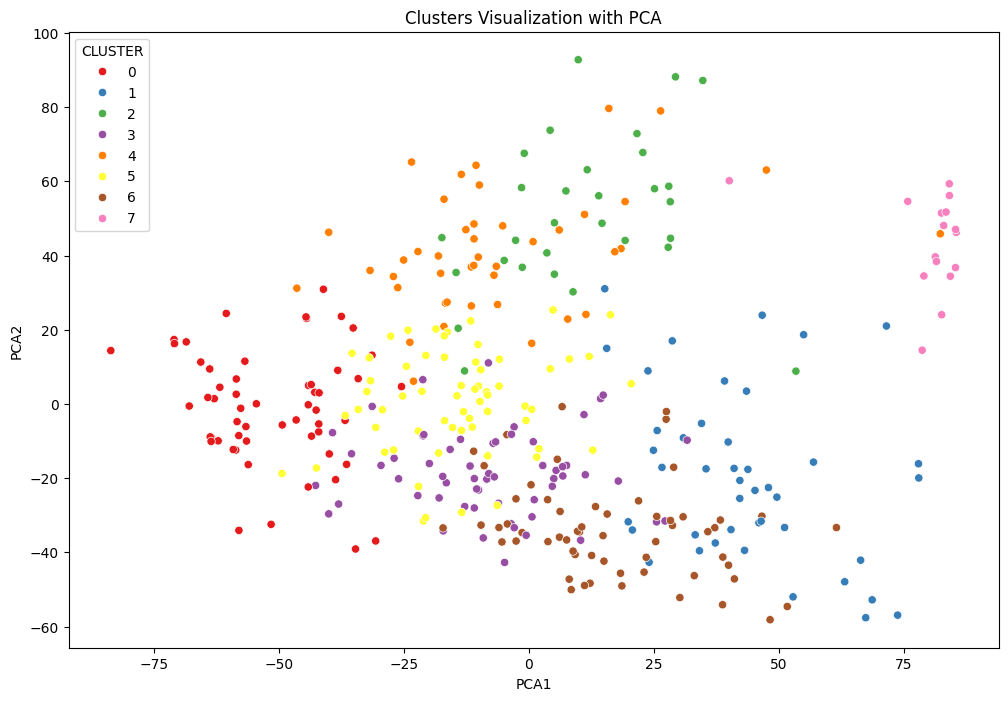

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming result17_18 is your final DataFrame with clustering results
# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(result18_19.drop(['PLAYER', 'TEAM', 'CLUSTER'], axis=1))

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CLUSTER'] = result18_19['CLUSTER']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='CLUSTER', palette='Set1', data=pca_df, legend='full')
plt.title('Clusters Visualization with PCA')
plt.show()

In [ ]:
# clusters.loc[:,['PLAYER', 'SILHOUETTE COEFFICIENT'] + col_names].sort_values(by=['SILHOUETTE COEFFICIENT'],ascending=False)

In [ ]:
for i in range(8):
  print(f"CLUSTER {i}")
  print(result18_19.loc[result18_19['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
107             Lauri Markkanen
112               Mikal Bridges
137                  Saddiq Bey
147               Davis Bertans
163                  Jeff Green
166          Reggie Bullock Jr.
167              Oshae Brissett
173              Justin Holiday
183                 Jae Crowder
186         Dorian Finney-Smith
188    Kentavious Caldwell-Pope
189                Mike Muscala
194             Cameron Johnson
197                 Danny Green
198                Trevor Ariza
203                   Josh Hart
228            Robert Covington
236              Sterling Brown
239              JaMychal Green
240               Nicolas Batum
259              Garrett Temple
262            Patrick Beverley
270         Juancho Hernangomez
274               Kent Bazemore
276                 Maxi Kleber
280               Royce O'Neale
282               Georges Niang
286           Derrick Jones Jr.
287             Pat Connaughton
288             Jaden McDaniels
294             Markieff Morri

In [ ]:
cols = [f'CLUSTER {i} DISTANCE' for i in range(8)]
cols = ['PLAYER', 'CLUSTER', 'SILHOUETTE COEFFICIENT'] + cols
result18_19.loc[:, cols]

,PLAYER,CLUSTER,SILHOUETTE COEFFICIENT,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE
0,Stephen Curry,1,0.070053,9.545063,5.310168,11.858369,6.283617,9.536304,8.527519,6.501111,12.816062
1,Bradley Beal,1,0.014140,8.522876,4.047651,9.491152,4.708161,7.467927,6.244006,5.492995,10.877529
2,Damian Lillard,1,0.204870,11.824366,4.708275,13.199306,8.838136,11.158635,10.175441,6.896735,13.837590
3,Joel Embiid,4,0.182430,9.938024,8.947505,7.284963,9.348949,5.354069,8.188885,9.987098,9.086569
4,Giannis Antetokounmpo,1,0.174537,10.350522,5.505387,8.466416,8.618898,7.158732,8.057147,7.754583,9.002557
...,...,...,...,...,...,...,...,...,...,...,...
364,P.J. Tucker,0,0.238348,5.930513,12.475270,11.600804,9.445308,9.832100,8.221087,10.696062,13.975904
365,Romeo Langford,5,0.166749,4.493208,8.193566,7.823766,5.296034,6.076639,3.065289,6.468686,10.492621
366,Gary Clark,0,0.207787,4.486547,10.564707,9.911095,7.437262,7.792573,6.217758,8.743057,12.149983
367,Matthew Dellavedova,6,0.272564,7.080620,6.067130,9.908947,6.065276,7.778488,5.773342,3.531924,11.582593
